In [537]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.api import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

Function for data frame manipulations that are same for all data frames.

In [538]:
def df_manipulation(path):
    data_frame = pd.read_csv(path)
    data_frame = data_frame.rename(columns={"Name": "Date"})
    data_frame["Date"] = pd.to_datetime(data_frame["Date"], format="%d/%m/%Y")
    data_frame['Date'] = data_frame['Date'].dt.strftime('%Y-%m')
    data_frame.set_index('Date', inplace=True)
    return data_frame

Dependant variable data frame

In [539]:
dependentVariable = df_manipulation('data/depVariable.csv')

Monthly data

In [540]:
monthlyIndex = df_manipulation('data/Monthly.csv')

Change variable

In [541]:
changeVariables = df_manipulation('data/changeVariable.csv')

Smoothed 10 years earnings to price ratio

In [542]:
smoothedEP = df_manipulation('data/smoothedPE.csv')

Variance data frame, I don't use df_manipulation function because we need day information.

In [543]:
stockVariance = pd.read_csv('data/stockVar.csv')
stockVariance = stockVariance.rename(columns={"Name": "Date"})
stockVariance["Date"] = pd.to_datetime(stockVariance["Date"], format="%d/%m/%Y")
stockVariance.set_index('Date', inplace=True)

stockVariance = stockVariance.rename(columns={"JAPAN-DS Market - PRICE INDEX": "var"})

Net equity expansion

In [544]:
netIssue = df_manipulation('data/netEquExp.csv')

In [545]:
notCompVwretd = pd.DataFrame(dependentVariable["JAPAN-DS Market - TOT RETURN IND"].pct_change(1) - ((dependentVariable["JP OVERNIGHT UNCOLLATERISED CALL MONEY RATE (AVG.) NADJ"]/100)/12))

Excess market return following Li et al (2013) for regression: log(1+ret%) - log (1+tbill%)

In [546]:
dependentVariable["JAPAN-DS Market - TOT RETURN IND"] = np.log(dependentVariable["JAPAN-DS Market - TOT RETURN IND"]/dependentVariable["JAPAN-DS Market - TOT RETURN IND"].shift(1))

dependentVariable["JP OVERNIGHT UNCOLLATERISED CALL MONEY RATE (AVG.) NADJ"] = np.log(1+(dependentVariable["JP OVERNIGHT UNCOLLATERISED CALL MONEY RATE (AVG.) NADJ"]/100)/12)

dependentVariable["JAPAN-DS Market - TOT RETURN IND"] -= dependentVariable["JP OVERNIGHT UNCOLLATERISED CALL MONEY RATE (AVG.) NADJ"]

dependentVariable = dependentVariable.drop(columns=["JP OVERNIGHT UNCOLLATERISED CALL MONEY RATE (AVG.) NADJ"])
dependentVariable = dependentVariable.rename(columns={"JAPAN-DS Market - TOT RETURN IND": "totalReturnChange"})
dependentVariable = dependentVariable.dropna()


/Users/jessekeranen/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Help variables for valuation ratios

In [547]:
dividends = monthlyIndex["JAPAN-DS Market - PRICE INDEX"]/monthlyIndex["JAPAN-DS Market - TOT RETURN IND"]
price = dividends/monthlyIndex["JAPAN-DS Market - DIVIDEND YIELD"]*100
earnings = price/monthlyIndex["JAPAN-DS Market - PER"]
dividendPriceRatio = pd.DataFrame(monthlyIndex["JAPAN-DS Market - DIVIDEND YIELD"]/100)
dividendPriceRatio = dividendPriceRatio.rename(columns={dividendPriceRatio.columns[0]: "D/P"})
bookToMarketRatio = 1/pd.DataFrame(monthlyIndex["JAPAN-DS Market - PRICE/BOOK RATIO"])
bookToMarketRatio = bookToMarketRatio.rename(columns={"JAPAN-DS Market - PRICE/BOOK RATIO": "B/M"})

earningsToPriceRatio = 1/pd.DataFrame(monthlyIndex["JAPAN-DS Market - PER"])
earningsToPriceRatio = earningsToPriceRatio.rename(columns={"JAPAN-DS Market - PER": "E/P"})

Volatility and variance variables

In [548]:
volatilityIndex = pd.DataFrame(np.log(1 + changeVariables["NIKKEI STOCK AVERAGE VOLATILITY INDEX - PRICE INDEX"].diff() / changeVariables["NIKKEI STOCK AVERAGE VOLATILITY INDEX - PRICE INDEX"].shift(1)))

volatilityIndex = volatilityIndex.dropna()
volatilityIndex = volatilityIndex.rename(columns={volatilityIndex.columns[0]: "Vola"})

/Users/jessekeranen/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [549]:
stockVariance = pd.DataFrame((stockVariance["var"].diff() / stockVariance["var"].shift(1)).dropna())

In [550]:
stockVariance = stockVariance.groupby(stockVariance.index.to_period('M')).agg("var")["var"]
stockVariance.index = volatilityIndex.index

In [551]:
sDividends = smoothedEP["JAPAN-DS Market - PRICE INDEX"]/smoothedEP["JAPAN-DS Market - TOT RETURN IND"]
sPrice = sDividends/smoothedEP["JAPAN-DS Market - DIVIDEND YIELD"]*100
sEarnings = sPrice/smoothedEP["JAPAN-DS Market - PER"]
sEarnings = sEarnings.rolling(119).mean()
smoothedEP = sEarnings.dropna()

# Dates for December 1989 don't match in price and smoothedEP, so I change them manually.
price1 = price.copy()
price1.index.array[0] = '1989-12-29'

smoothedEP = (1/price1/smoothedEP).dropna()

# Small difference again, but not big
smoothedEP = pd.DataFrame(smoothedEP)
smoothedEP = smoothedEP.rename(columns={smoothedEP.columns[0]: "E10/P"})

In [552]:
percentEquityIssuing = pd.DataFrame(monthlyIndex["JP STOCKS: PUBLIC OFFERINGS - AMOUNT RAISED CURN"]/(monthlyIndex["JP ISSUES: CORPORATE STRAIGHT BONDS CURN"] + monthlyIndex["JP STOCKS: PUBLIC OFFERINGS - AMOUNT RAISED CURN"]))
percentEquityIssuing = pd.DataFrame(percentEquityIssuing.fillna(0))
percentEquityIssuing = percentEquityIssuing.rename(columns={percentEquityIssuing.columns[0]: "Equis"})

inflationRate = pd.DataFrame(monthlyIndex["JP CPI: NATIONAL MEASURE - ANNUAL INFLATION RATE NADJ"]/100)
inflationRate = inflationRate.rename(columns={inflationRate.columns[0]: "Ifl"})

In [553]:
def change(x, column):
    return pd.DataFrame((x[column].diff() / x[column].shift(1)).dropna())

In [554]:
realMoneySupply = change(changeVariables, "JP MONEY SUPPLY: M2 (METHO-BREAK, APR. 2003) CURA")
realMoneySupply = realMoneySupply.rename(columns={realMoneySupply.columns[0]: "Rms"})

petroleumConsumption = change(changeVariables, "JP PETROLEUM: CONSUMPTION VOLN")
petroleumConsumption = petroleumConsumption.rename(columns={petroleumConsumption.columns[0]: "PCon"})
unemploymentRate = change(changeVariables, "JP UNEMPLOYMENT RATE (METHO BREAK OCT 2010) SADJ")
unemploymentRate = unemploymentRate.rename(columns={unemploymentRate.columns[0]: "Unem"})
industrialProduction = change(changeVariables, "JP INDUSTRIAL PRODUCTION - MINING & MANUFACTURING VOLA")
industrialProduction = industrialProduction.rename(columns={industrialProduction.columns[0]: "IProd"})
crudeOilPriceChange = change(changeVariables, "US REFINERS ACQUISITION COST OF DOM. & IMPORTED CRUDE OIL CURN")
crudeOilPriceChange = crudeOilPriceChange.rename(columns={crudeOilPriceChange.columns[0]: "C/P"})
crudeOilProduction = change(changeVariables, "WD CRUDE OIL PRODUCTION - WORLD VOLN")
crudeOilProduction = crudeOilProduction.rename(columns={crudeOilProduction.columns[0]: "C/O"})

In [555]:
mv = netIssue["JAPAN-DS Market - MARKET VALUE"]

temp9 = netIssue["JAPAN-DS Market - PRICE INDEX"].diff() / netIssue["JAPAN-DS Market - PRICE INDEX"].shift(1)
netIssue = netIssue["JAPAN-DS Market - MARKET VALUE"] - netIssue["JAPAN-DS Market - MARKET VALUE"].shift(1)*(1+temp9)

#Slight differences again, could be because of rolling functions
netIssue = (netIssue.rolling(window=12, min_periods=3).sum()).dropna()
netIssue = (netIssue/mv).dropna()
netIssue = pd.DataFrame(netIssue)
netIssue = netIssue.rename(columns={netIssue.columns[0]: "Ntis"})

In [556]:
netPY = (monthlyIndex["JAPAN-DS Market - DIVIDEND YIELD"]/100) + (((changeVariables["JAPAN-DS Market - MARKET VALUE"].shift(1) * (changeVariables["JAPAN-DS Market - PRICE INDEX"]/changeVariables["JAPAN-DS Market - PRICE INDEX"].shift(1))) - changeVariables["JAPAN-DS Market - MARKET VALUE"])/changeVariables["JAPAN-DS Market - MARKET VALUE"])
netPY = pd.DataFrame((np.log(0.1 + netPY)).dropna())
netPY = netPY.rename(columns={netPY.columns[0]: "Ndy"})

/Users/jessekeranen/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [557]:
def rollingmean(length):
    temp = dependentVariable.rolling(length).mean().shift(-length)
    #temp["totalReturnChange"] = temp["totalReturnChange"].shift(1)
    temp = temp.rename(columns={temp.columns[0]: ("K" + str(length))})
    return pd.DataFrame(temp)

In [558]:
mk12 = rollingmean(12)
mk24 = rollingmean(24)
mk36 = rollingmean(36)
mk48 = rollingmean(48)

Fama and French factors

In [559]:
famafrench = pd.read_csv("data/Japan_5_Factors.csv")
famafrench["Date"] = pd.to_datetime(famafrench["Date"], format="%Y%m")
famafrench['Date'] = famafrench['Date'].dt.strftime('%Y-%m')
famafrench.set_index('Date', inplace=True)
famafrench = famafrench.loc[:].div(100)
famafrench = famafrench.drop(columns={"RF"})

mom = pd.read_csv("data/Japan_MOM_Factor.csv")
mom['Date'] = pd.to_datetime(mom["Date"], format="%Y%m")
mom['Date'] = mom['Date'].dt.strftime('%Y-%m')
mom.set_index('Date', inplace=True)
mom = mom.loc[:].div(100)

In [560]:
finalmonthlyOnlyIV = dividendPriceRatio.merge(bookToMarketRatio, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(earningsToPriceRatio, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(smoothedEP, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(percentEquityIssuing, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(netIssue, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(netPY, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(inflationRate, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(realMoneySupply, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(crudeOilPriceChange, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(crudeOilProduction, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(petroleumConsumption, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(industrialProduction, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(unemploymentRate, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(stockVariance, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(volatilityIndex, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(famafrench, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(mom, on="Date")

In [561]:
finalmonthlyOnlyIV

,D/P,B/M,E/P,E10/P,Equis,Ntis,Ndy,Ifl,Rms,C/P,...,IProd,Unem,var,Vola,Mkt-RF,SMB,HML,RMW,CMA,WML
Date,,,,,,,,,,,,,,,,,,,,,
1990-11,0.0076,0.452489,0.027174,0.004159,0.000000,0.048690,-2.229692,0.0392,-0.003211,-0.079059,...,-0.007233,-0.090909,0.000253,-0.306572,-0.1412,-0.0520,-0.0020,0.0386,-0.0218,0.0150
1990-12,0.0072,0.431034,0.025907,0.003940,0.000000,0.042562,-2.259815,0.0370,0.002183,-0.145151,...,0.000000,0.000000,0.000260,-0.162792,0.0193,-0.0611,-0.0361,0.0123,0.0187,-0.0804
1991-01,0.0073,0.442478,0.026110,0.003995,0.001765,0.036230,-2.251344,0.0390,0.002065,-0.124186,...,0.009107,0.000000,0.000189,-0.115269,0.0119,-0.0773,0.0024,0.0218,0.0068,0.0046
1991-02,0.0064,0.380228,0.022989,0.003502,0.000754,0.029557,-2.243554,0.0356,0.000141,-0.167177,...,0.001805,0.050000,0.000151,-0.212098,0.1229,0.1132,0.0080,-0.0569,0.0074,-0.1523
1991-03,0.0064,0.381679,0.022831,0.003501,0.002583,0.028193,-2.240495,0.0366,0.000227,-0.059905,...,-0.010811,0.047619,0.000084,0.169855,-0.0421,0.0380,0.0040,0.0167,-0.0126,0.0145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05,0.0247,0.819672,0.059524,0.026802,0.000000,-0.008399,-2.065549,0.0000,0.016958,0.228233,...,-0.089120,0.115385,0.000138,-0.128674,0.0643,0.0287,-0.0739,0.0214,-0.0279,-0.0259
2020-06,0.0248,0.813008,0.059172,0.027017,0.000031,-0.010856,-2.065820,0.0010,0.021045,0.543624,...,0.019060,-0.034483,0.000180,0.053609,-0.0022,0.0033,-0.0397,0.0217,-0.0254,0.0463
2020-07,0.0254,0.840336,0.058480,0.027828,0.000223,-0.006121,-2.111701,0.0030,0.007901,0.088859,...,0.087282,0.035714,0.000108,-0.114868,-0.0198,-0.0177,-0.0276,0.0077,-0.0257,0.0679


In [562]:
dependentVariable["totalReturnChange"] = dependentVariable["totalReturnChange"].shift(-1)

dependentVariable

,totalReturnChange
Date,
1990-01,-0.074739
1990-02,-0.142811
1990-03,-0.009420
1990-04,0.087576
1990-05,-0.043173
...,...
2020-05,0.000052
2020-06,-0.035390
2020-07,0.076310


In [563]:
#dependentVariable["totalReturnChange"] = dependentVariable["totalReturnChange"].shift(-1)
dependentVariable = dependentVariable.dropna()
dependentVariable = dependentVariable.rename(columns={dependentVariable.columns[0]: "K1"})
finalIndexMonthly = finalmonthlyOnlyIV.merge(dependentVariable, on='Date')
finalIndexMonthly = finalIndexMonthly.merge(mk12, on='Date')
finalIndexMonthly = finalIndexMonthly.merge(mk24, on='Date')
finalIndexMonthly = finalIndexMonthly.merge(mk36, on='Date')
finalIndexMonthly = finalIndexMonthly.merge(mk48, on='Date')

In [564]:
finalIndexMonthly
finalIndexMonthly.to_csv("/Users/jessekeranen/Desktop/finalIndexMonthly.csv")

Some plotting and descriptive statistics

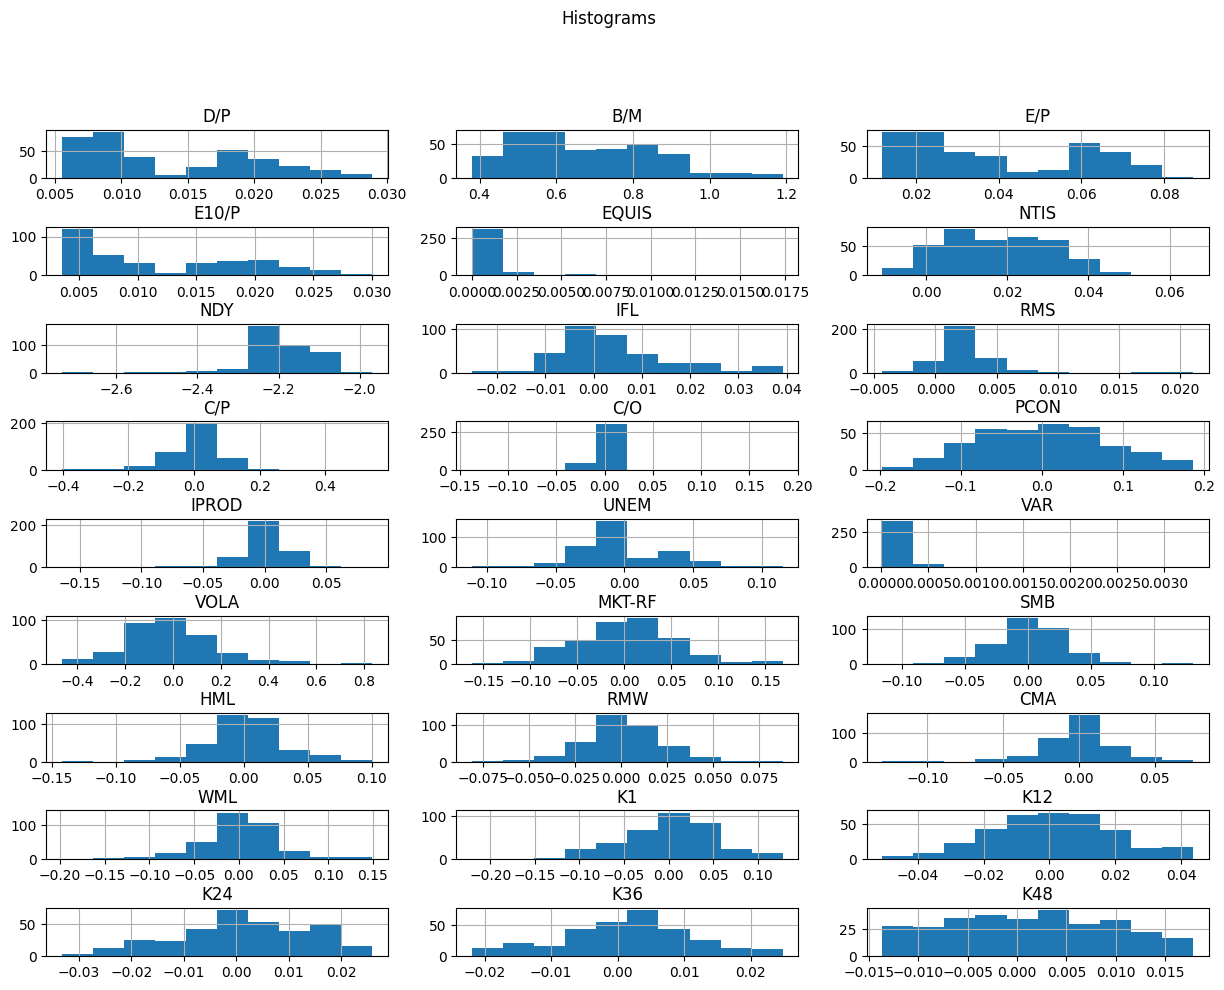

In [565]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=1)
plt.suptitle("Histograms")

for i, col in enumerate(finalIndexMonthly.columns):
    ax = plt.subplot(10, 3, i + 1)

    finalIndexMonthly[col].hist(ax=ax)

    ax.set_title(col.upper())
    ax.set_xlabel("")

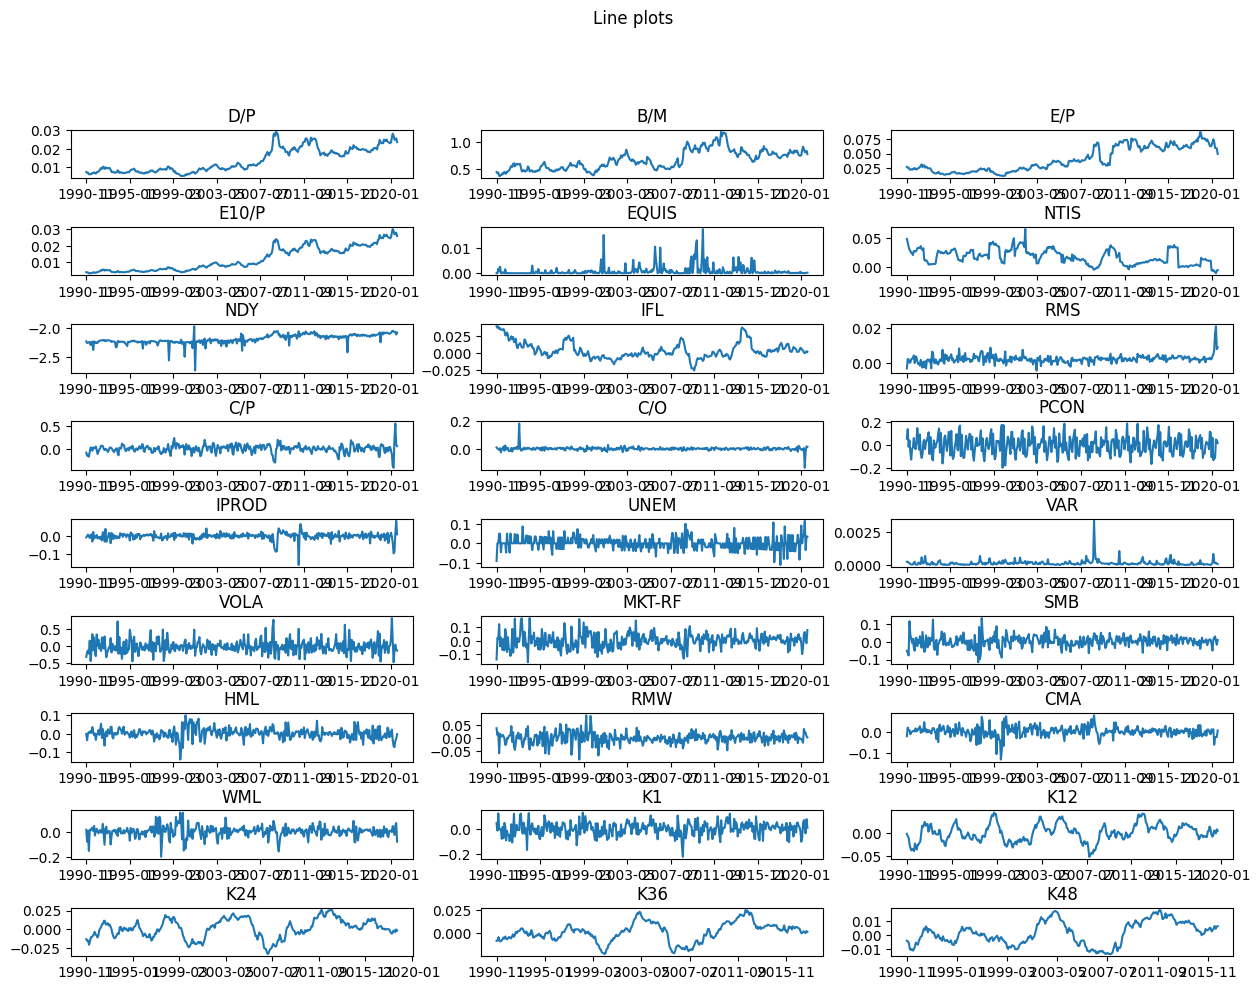

In [566]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=1)
plt.suptitle("Line plots")

for i, col in enumerate(finalIndexMonthly.columns):
    ax = plt.subplot(10, 3, i + 1)

    finalIndexMonthly[col].plot(ax=ax)

    ax.set_title(col.upper())
    ax.set_xlabel("")

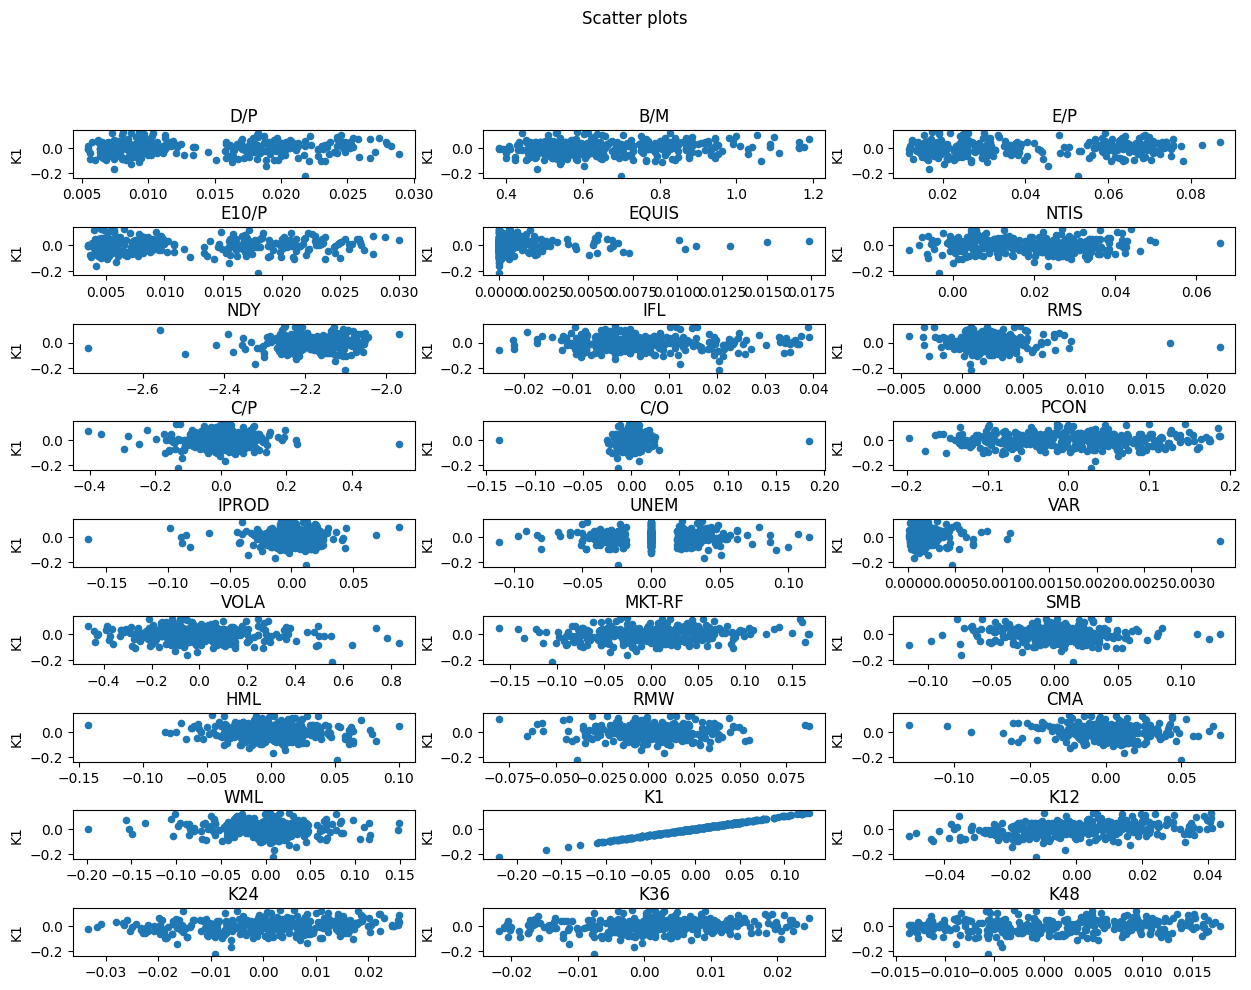

In [567]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=1)
plt.suptitle("Scatter plots")

for i, col in enumerate(finalIndexMonthly.columns):
    ax = plt.subplot(10, 3, i + 1)

    finalIndexMonthly.plot.scatter(x=col, y="K1", ax=ax)

    ax.set_title(col.upper())
    ax.set_xlabel("")

In [568]:
finalIndexMonthly.describe()

,D/P,B/M,E/P,E10/P,Equis,Ntis,Ndy,Ifl,Rms,C/P,...,SMB,HML,RMW,CMA,WML,K1,K12,K24,K36,K48
count,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,...,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,347.000000,335.000000,323.000000,311.000000
mean,0.013774,0.675412,0.039718,0.012039,0.000900,0.017604,-2.188767,0.004025,0.002279,0.004521,...,0.001067,0.002157,0.001450,0.000144,0.000861,0.000960,0.000644,0.001078,0.001313,0.001306
std,0.006300,0.176496,0.020787,0.007209,0.002066,0.013014,0.078314,0.011668,0.002266,0.086026,...,0.031617,0.029145,0.021194,0.023632,0.043503,0.051854,0.018388,0.012594,0.009961,0.008249
min,0.005500,0.380228,0.011848,0.003500,0.000000,-0.010856,-2.733845,-0.025200,-0.004347,-0.403687,...,-0.115300,-0.142500,-0.080900,-0.129900,-0.198300,-0.220489,-0.050797,-0.033273,-0.021915,-0.013649
25%,0.008300,0.529101,0.021277,0.005363,0.000007,0.007245,-2.235110,-0.003100,0.001106,-0.036608,...,-0.015000,-0.013200,-0.009475,-0.011075,-0.017500,-0.030374,-0.011899,-0.007123,-0.004515,-0.004933
50%,0.011100,0.647256,0.031746,0.009002,0.000159,0.015781,-2.204448,0.002000,0.002187,0.011855,...,0.002350,0.002550,0.001100,0.000850,0.004950,0.002626,0.000527,0.001420,0.001897,0.001250
75%,0.019275,0.806452,0.061256,0.017945,0.000766,0.027721,-2.130326,0.008300,0.003173,0.055082,...,0.019750,0.017750,0.012825,0.012075,0.021400,0.035943,0.013028,0.011066,0.007633,0.008110
max,0.028900,1.190476,0.086957,0.030040,0.017385,0.065781,-1.968756,0.039200,0.021045,0.543624,...,0.131000,0.100500,0.087900,0.075400,0.149500,0.128005,0.043606,0.025901,0.024836,0.017832


In [569]:
#addingsStarts
def addStars(data):
    if data <= 0.01:
        return str(data) + "***"
    elif data <= 0.05:
        return str(data) + "**"
    elif data <= 0.1:
        return str(data) + "*"
    else:
        return str(data)
  

Univariate insample results

In [570]:
#i first make a listoflist to dynamically fill the table with strings and integers
#afterwards I convert it to a DataFrame
listoflist = list()

#for every independent variable
for i in finalmonthlyOnlyIV.columns:
    listoflist.append(["Variable", i, "-", "-", "-"])
    #in the end i calculate the average coefficient of all the time periods
    averageOfCoefficients = list()
    
    #for all the time periods: K1, K12, K24, K36, K48
    for j in finalIndexMonthly.iloc[:,-5:].columns:
        #I use smf.ols, because this function enables the use of newey west SE. Thus y ~ x format is needed as a parameter to the function
        #Such as: 'K1 ~ 1 + Q("D/P")' - Q("x") is needed to adress special characters such as / & etc.
        #passing D/P directly doesnt work and the "1" is needed for the constant
        olsString = '' + j + ' ~ 1 + Q("' + i + '")'

        #I fit with newey west standard errors and lag of 1
        ols = smf.ols(olsString, data = finalIndexMonthly).fit(cov_type = 'HAC', cov_kwds={'maxlags':1})

        #add Stars to pvalue according to their significance levels
        pval = addStars(round(ols.pvalues[1],3))

        #period, coefficient of variable, newey west tstat, pvalue, r^2 adj value
        listoflist.append([j, round(ols.params[1],2), round(ols.tvalues[1],2), pval, round(ols.rsquared_adj,2)])

        averageOfCoefficients.append(ols.params[1])
    listoflist.append(["Avg", round(np.mean(averageOfCoefficients),2), "-", "-", "-"])

resultsUV = pd.DataFrame(listoflist)
resultsUV.columns = ["Time Horizon", "Coefficient (b)", "NW t-stat", "pval", "R^2 adj"]

#set first column as index of dataframe
resultsUV = resultsUV.set_index(resultsUV.iloc[:,0].values)
resultsUV = resultsUV.drop(resultsUV.columns[0], axis=1)     
resultsUV

,Coefficient (b),NW t-stat,pval,R^2 adj
Variable,D/P,-,-,-
K1,0.59,1.26,0.207,0.0
K12,0.85,4.52,0.0***,0.08
K24,0.79,5.88,0.0***,0.13
K36,0.75,6.41,0.0***,0.19
...,...,...,...,...
K12,-0.0,-0.1,0.92,-0.0
K24,0.0,0.09,0.932,-0.0
K36,0.0,0.01,0.992,-0.0
K48,-0.01,-1.24,0.215,0.0


Multivariate insample results

In [571]:
test = finalIndexMonthly.iloc[:, :-5]
features = list(test.columns)
features.insert(0, "const")
#X = test.values.tolist()
#X = sm.add_constant(X)
#y = finalIndexMonthly["K1"].tolist()
#ols = sm.OLS(y, X).fit()

timePeriod = "K1" #change this to K12, K24, K36, K48
olsString = timePeriod + ' ~ 1'
for i in finalmonthlyOnlyIV.columns:
    olsString = olsString + ' + Q("' + i + '")'

#I fit with newey west standard errors and lag of 1
ols = smf.ols(olsString, data = finalIndexMonthly).fit(cov_type = 'HAC', cov_kwds={'maxlags':1})

print(ols.summary(xname=features))

                            OLS Regression Results                            
Dep. Variable:                     K1   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     1.866
Date:                Sun, 01 Jan 2023   Prob (F-statistic):             0.0112
Time:                        16:34:01   Log-Likelihood:                 570.59
No. Observations:                 358   AIC:                            -1095.
Df Residuals:                     335   BIC:                            -1006.
Df Model:                          22                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1396      0.126      1.108      0.2

Ask Jesse
What are these two code snippets?
-> Basically the same as out of sample right?

In [572]:
multivariate_results = ols.summary#(xnames = features)

In [573]:
#pred = ols.predict(X)
#plt.scatter(y, pred)

Correlations

In [574]:
correlations = test.corr()

correlations

,D/P,B/M,E/P,E10/P,Equis,Ntis,Ndy,Ifl,Rms,C/P,...,IProd,Unem,var,Vola,Mkt-RF,SMB,HML,RMW,CMA,WML
D/P,1.000000,0.878758,0.924519,0.979612,0.067487,-0.558504,0.783946,-0.086736,0.205332,-0.057296,...,-0.114210,-0.015883,0.157872,0.019099,-0.003537,0.065888,-0.122661,0.011107,0.005273,-0.022406
B/M,0.878758,1.000000,0.815564,0.847941,0.131694,-0.366091,0.674199,-0.248634,0.139240,-0.043093,...,-0.067285,-0.047278,0.107360,0.010810,-0.010951,0.092501,-0.083446,0.019606,0.014239,-0.019647
E/P,0.924519,0.815564,1.000000,0.940962,0.033585,-0.514956,0.732764,0.061185,0.138903,-0.081748,...,-0.105846,-0.082556,0.097883,0.020027,-0.009158,0.052297,-0.104800,-0.001850,0.029463,-0.010749
E10/P,0.979612,0.847941,0.940962,1.000000,0.053215,-0.547231,0.767440,-0.102041,0.241165,-0.039489,...,-0.089741,-0.035999,0.102741,0.016073,0.017824,0.071196,-0.131953,0.019956,-0.016541,-0.015903
Equis,0.067487,0.131694,0.033585,0.053215,1.000000,0.112218,0.027380,-0.188877,-0.043094,0.056444,...,0.095890,-0.084884,-0.039929,0.008344,-0.005824,0.036115,0.138064,0.021313,-0.023229,0.016883
Ntis,-0.558504,-0.366091,-0.514956,-0.547231,0.112218,1.000000,-0.523944,-0.118097,-0.154884,0.039284,...,0.063920,-0.046381,-0.060621,-0.030149,-0.091525,0.003445,0.087926,0.060130,-0.037908,0.005917
Ndy,0.783946,0.674199,0.732764,0.767440,0.027380,-0.523944,1.000000,-0.036258,0.147318,-0.026942,...,-0.104374,-0.033731,0.127251,0.110479,-0.055950,0.045000,-0.101460,0.036788,-0.047469,0.003978
Ifl,-0.086736,-0.248634,0.061185,-0.102041,-0.188877,-0.118097,-0.036258,1.000000,-0.091868,-0.226461,...,-0.110901,-0.008730,0.028348,0.014938,-0.079899,-0.084735,-0.008885,-0.003424,0.098427,0.005872
Rms,0.205332,0.139240,0.138903,0.241165,-0.043094,-0.154884,0.147318,-0.091868,1.000000,0.153182,...,-0.045353,0.094643,-0.061406,-0.071828,0.057002,0.032546,-0.168408,0.026664,-0.114512,-0.006446
C/P,-0.057296,-0.043093,-0.081748,-0.039489,0.056444,0.039284,-0.026942,-0.226461,0.153182,1.000000,...,0.184944,-0.120190,-0.245660,-0.049910,0.158908,0.056661,-0.002207,-0.011851,-0.101950,-0.050247


VIF

In [575]:
vif_df = finalmonthlyOnlyIV
vif = pd.DataFrame()
vif["Variable"] = vif_df.columns
vif["VIF"] = [variance_inflation_factor(vif_df.values, column) for column in range(len(vif_df.columns))]

maxim = vif.loc[vif["VIF"] == vif["VIF"].max()].reset_index(drop=True)

maxim

while maxim["VIF"][0] > 10:
    vif_df = vif_df.drop(columns={maxim["Variable"][0]})
    vif = pd.DataFrame()
    vif["Variable"] = vif_df.columns
    vif["VIF"] = [variance_inflation_factor(vif_df.values, column) for column in range(len(vif_df.columns))]
    maxim = vif.loc[vif["VIF"] == vif["VIF"].max()].reset_index(drop=True)

vif

,Variable,VIF
0,E10/P,2.660585
1,Equis,1.331922
2,Ntis,1.750291
3,Ifl,1.173954
4,Rms,2.251649
5,C/P,1.254030
6,C/O,1.132028
7,PCon,1.114448
8,IProd,1.176859
9,Unem,1.096258


In [576]:
#cols = vif_df.columns
#X = finalIndexMonthly[cols]
#X = sm.add_constant(X)

#cols = cols.insert(0, "const")
#y = finalIndexMonthly["K1"]
#vif_ols = sm.OLS(y, X).fit()

timePeriod = "K1" #change this to K12, K24, K36, K48
olsString = timePeriod + ' ~ 1'
for i in vif_df.columns:
    olsString = olsString + ' + Q("' + i + '")'

#I fit with newey west standard errors and lag of 1
vif_ols = smf.ols(olsString, data = finalIndexMonthly).fit(cov_type = 'HAC', cov_kwds={'maxlags':1})

print(vif_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                     K1   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.516
Date:                Sun, 01 Jan 2023   Prob (F-statistic):             0.0816
Time:                        16:34:02   Log-Likelihood:                 561.94
No. Observations:                 358   AIC:                            -1086.
Df Residuals:                     339   BIC:                            -1012.
Df Model:                          18                                         
Covariance Type:                  HAC                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0040      0.010     -0.411      

Utility Calculation

In [595]:
indexTemp = finalIndexMonthly.index
#historical average market return
hmean = list()
for i in indexTemp:
    hmean.append(finalIndexMonthly.loc[:,"K1"].loc["1990-11":i].mean())
#historical average market return

# This is new
# I moved rhmean one step "forward" to avoid forward looking information
# rhmean = pd.Series(hmean)
# rhmean = rhmean.shift(1)
rhmean = pd.Series(hmean[finalIndexMonthly.index.get_loc("2001-12"):])
rhmean = rhmean.reset_index(drop=True)



#utility gain
riskAversion = 3
varianceUT = finalIndexMonthly.loc[:,"K1"]*100
#utilityDF
varianceUT = varianceUT.rolling(len(varianceUT),min_periods=12*10).var().loc["2001-12":]
rhmean.index = varianceUT.index
wVariable = (rhmean*100).div(varianceUT)*(1/riskAversion)


#restrict wVariable to max 0% or 150%
wVariable
for i in wVariable.index:
    if wVariable[i] < 0:
        wVariable[i] = 0
    elif wVariable[i] > 1.5:
        wVariable[i] = 1.5
    else:
        True
        #do nothing
historicUtility = wVariable.mean()-(1/2*riskAversion*wVariable.var())

Out of sample predictions. Have to consider should we add constants also here?

Speak with jesse

I think yes

Also this is only the kitchen sink model.

In [578]:
# Add constants to the model
finalmonthlyOnlyIVConst = finalmonthlyOnlyIV.copy(deep=True)
finalmonthlyOnlyIVConst.insert(0, "const", 1)

finalIndexMonthlyConst = finalIndexMonthly.copy(deep=True)
finalIndexMonthlyConst.insert(0, "const", 1)
finalIndexMonthlyConst

,const,D/P,B/M,E/P,E10/P,Equis,Ntis,Ndy,Ifl,Rms,...,SMB,HML,RMW,CMA,WML,K1,K12,K24,K36,K48
Date,,,,,,,,,,,,,,,,,,,,,
1990-11,1,0.0076,0.452489,0.027174,0.004159,0.000000,0.048690,-2.229692,0.0392,-0.003211,...,-0.0520,-0.0020,0.0386,-0.0218,0.0150,0.044476,-0.001711,-0.013373,-0.007927,-0.004166
1990-12,1,0.0072,0.431034,0.025907,0.003940,0.000000,0.042562,-2.259815,0.0370,0.002183,...,-0.0611,-0.0361,0.0123,0.0187,-0.0804,-0.014174,-0.006724,-0.015631,-0.007854,-0.004589
1991-01,1,0.0073,0.442478,0.026110,0.003995,0.001765,0.036230,-2.251344,0.0390,0.002065,...,-0.0773,0.0024,0.0218,0.0068,0.0046,0.121963,-0.009776,-0.015301,-0.004005,-0.005820
1991-02,1,0.0064,0.380228,0.022989,0.003502,0.000754,0.029557,-2.243554,0.0356,0.000141,...,0.1132,0.0080,-0.0569,0.0074,-0.1523,0.001511,-0.023902,-0.020829,-0.007318,-0.010064
1991-03,1,0.0064,0.381679,0.022831,0.003501,0.002583,0.028193,-2.240495,0.0366,0.000227,...,0.0380,0.0040,0.0167,-0.0126,0.0145,-0.009280,-0.032089,-0.016152,-0.008653,-0.010574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04,1,0.0267,0.877193,0.069930,0.028855,0.000047,-0.007739,-2.061946,0.0010,0.007481,...,0.0220,-0.0700,0.0359,-0.0612,0.0109,0.068696,NaN,NaN,NaN,NaN
2020-05,1,0.0247,0.819672,0.059524,0.026802,0.000000,-0.008399,-2.065549,0.0000,0.016958,...,0.0287,-0.0739,0.0214,-0.0279,-0.0259,0.000052,NaN,NaN,NaN,NaN
2020-06,1,0.0248,0.813008,0.059172,0.027017,0.000031,-0.010856,-2.065820,0.0010,0.021045,...,0.0033,-0.0397,0.0217,-0.0254,0.0463,-0.035390,NaN,NaN,NaN,NaN


In [579]:
dates = finalIndexMonthly.loc["2002-01":].index
results = np.empty(shape=(0, 4))
predictions = []

for date in dates:
    out_of_sample = finalIndexMonthlyConst.loc[date].iloc[:-5]

    df = finalIndexMonthlyConst.loc[:date].iloc[:-1, :-4]
    X = df.iloc[:, :-1]
    #X = sm.add_constant(X)
    y = df.iloc[:, -1:]
    ols = sm.OLS(y, X).fit()
    temp = np.matrix([[date] * len(ols.params)] + [ols.params.tolist()] + [ols.tvalues.tolist()] + [ols.params.index.tolist()])

    temp = np.transpose(temp)
    results = np.vstack((results, temp))

    prediction = [date, ols.predict(out_of_sample)[0]]
    predictions.append(prediction) #same as oospread

pred_df = pd.DataFrame(predictions)
pred_df = pred_df.rename(columns={0: "Date", 1: "Pred"})
pred_df.set_index('Date', inplace=True)

results = pd.DataFrame(results)
results = results.rename(columns={0: "Date", 1: "Coef", 2: "T-val", 3: "Variable"})
results.set_index("Date", inplace=True)

results[["Coef", "T-val"]] = results[["Coef", "T-val"]].apply(pd.to_numeric)
results = results.round(2)
#results

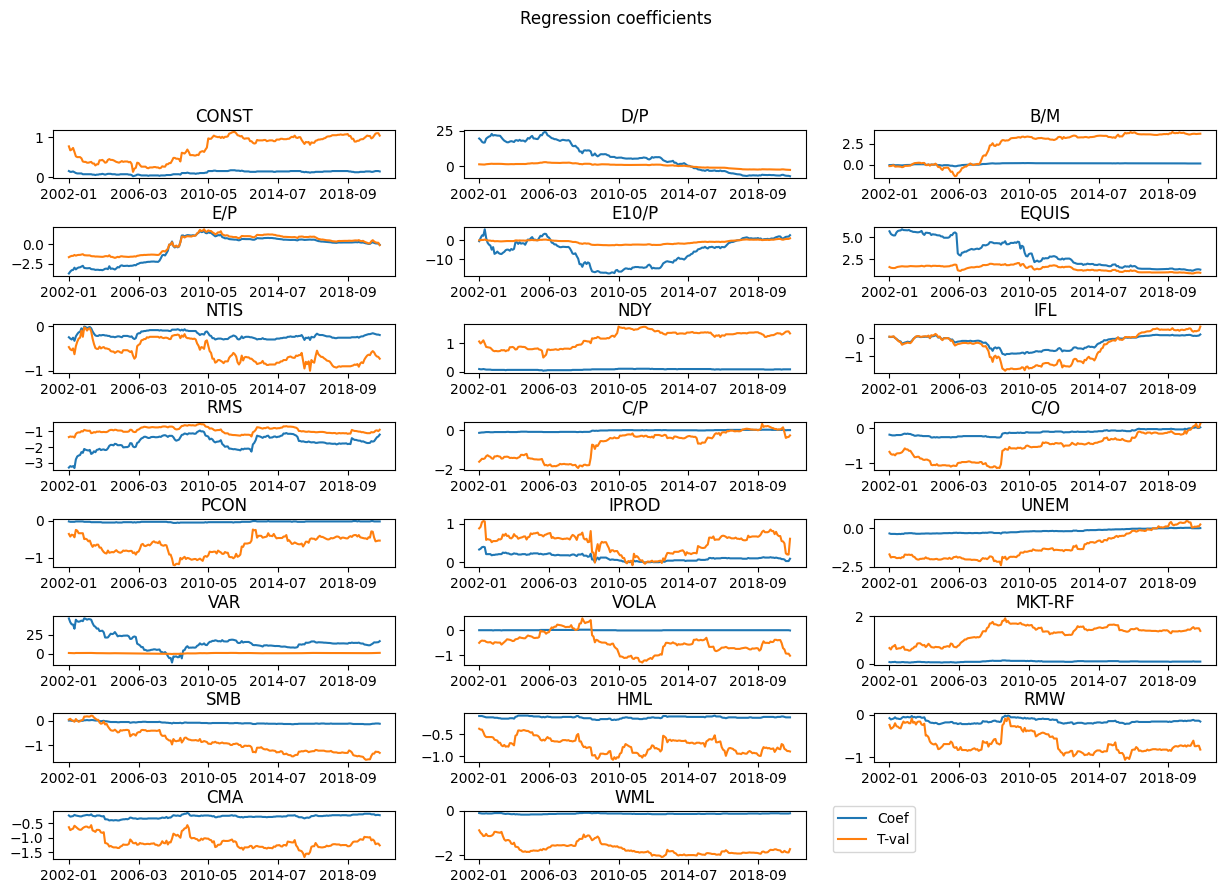

In [580]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=1)
plt.suptitle("Regression coefficients")

for i, variable in enumerate(features[0:]):
    ax = plt.subplot(10, 3, i + 1)

    results[results["Variable"] == variable].plot(ax=ax)

    ax.set_title(variable.upper())
    ax.get_legend().remove()
    ax.set_xlabel("")

plt.legend(loc="lower center", bbox_to_anchor=(1.2, 0))
plt.show()

In [581]:
cols = vif_df.columns
cols = cols.insert(0, "const")
cols = cols.insert(0, "K1")
#X = finalIndexMonthlyC[cols]

dates = finalIndexMonthly.loc["2002-01":].index
results_vif = np.empty(shape=(0, 4))
predictions_vif = []

for date in dates:
    out_of_sample = finalIndexMonthlyConst.loc[date, cols[1:]]

    df = finalIndexMonthlyConst.loc[:date, cols].iloc[:-1]
    X = df.iloc[:, 1:]
    #X = sm.add_constant(X)
    y = df.iloc[:, 0]
    ols = sm.OLS(y, X).fit()
    temp = np.matrix([[date] * len(ols.params)] + [ols.params.tolist()] + [ols.tvalues.tolist()] + [ols.params.index.tolist()])

    temp = np.transpose(temp)
    results_vif = np.vstack((results_vif, temp))

    prediction_vif = [date, ols.predict(out_of_sample)[0]]
    predictions_vif.append(prediction_vif) #same as oospread

pred_df_vif = pd.DataFrame(predictions_vif)
pred_df_vif = pred_df_vif.rename(columns={0: "Date", 1: "Pred_vif"})
pred_df_vif.set_index('Date', inplace=True)

results_vif = pd.DataFrame(results_vif)
results_vif = results_vif.rename(columns={0: "Date", 1: "Coef", 2: "T-val", 3: "Variable"})
results_vif.set_index("Date", inplace=True)

results_vif[["Coef", "T-val"]] = results_vif[["Coef", "T-val"]].apply(pd.to_numeric)
results_vif = results_vif.round(2)

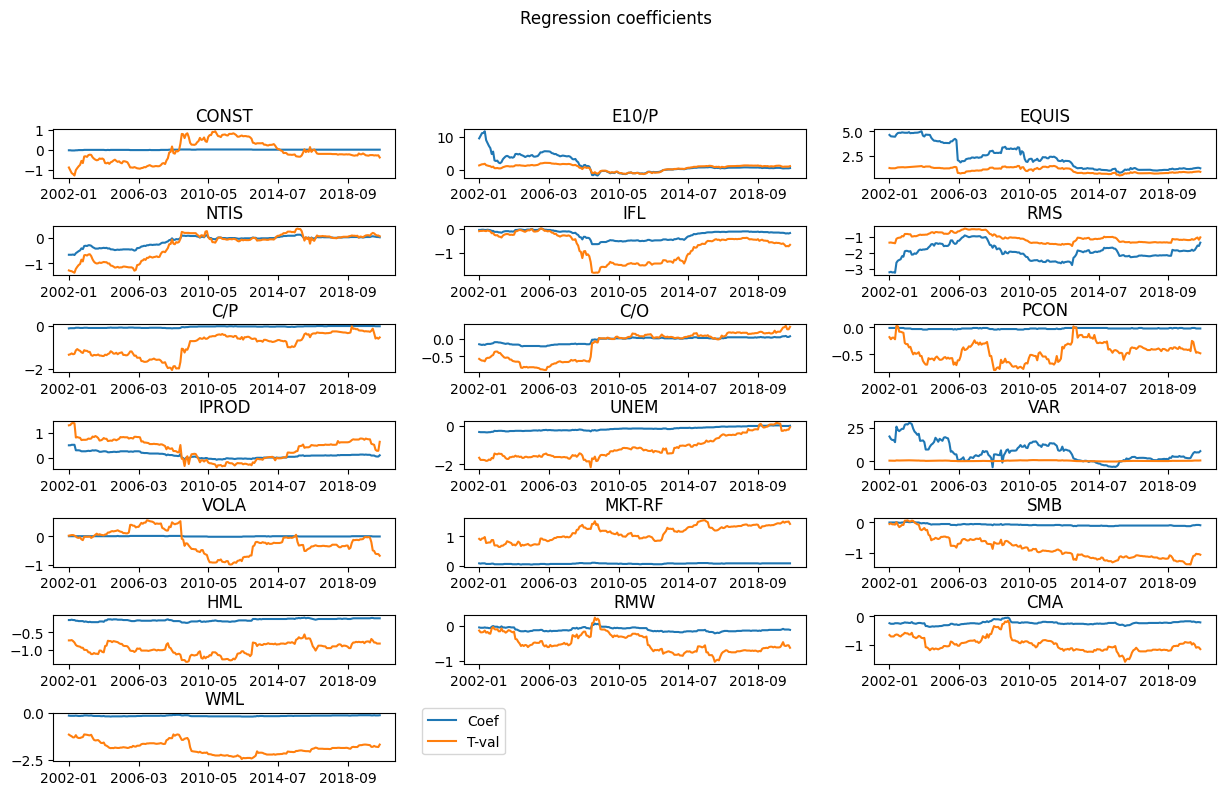

In [582]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=1)
plt.suptitle("Regression coefficients")

for i, variable in enumerate(cols[1:]):
    ax = plt.subplot(10, 3, i + 1)

    results_vif[results_vif["Variable"] == variable].plot(ax=ax)

    ax.set_title(variable.upper())
    ax.get_legend().remove()
    ax.set_xlabel("")

plt.legend(loc="lower center", bbox_to_anchor=(1.2, 0))
plt.show()

Calculation of R^2

In [583]:
realReturns = finalIndexMonthly.loc["2002-01":,"K1"]
realReturns

Date
2002-01    0.040751
2002-02    0.048307
2002-03    0.020142
2002-04    0.035865
2002-05   -0.087744
             ...   
2020-04    0.068696
2020-05    0.000052
2020-06   -0.035390
2020-07    0.076310
2020-08    0.008353
Name: K1, Length: 224, dtype: float64

In [596]:
dates = finalIndexMonthly.loc["2002-01":].index
anzahlIV = len(finalmonthlyOnlyIV.columns)
resultsForecastUV = np.zeros((anzahlIV,4))

figuresOosUV = list()

#average return past
# rhmean = pd.Series(hmean[finalIndexMonthly.index.get_loc("2002-01"):])

#real return
realReturns = finalIndexMonthly.loc["2002-01":,"K1"]
realReturns.index = rhmean.index

rapachTabelle = np.zeros((len(finalIndexMonthly.loc["2002-01":,]),anzahlIV))
rapachCounter = 0

for i, IV in enumerate(finalmonthlyOnlyIV.columns):
    oospread = list()
    oospreadCampbell = list()
    for j in dates:
        X = finalIndexMonthly.loc[:j,IV]
        y = finalIndexMonthly.loc[:j,"K1"]
        X = sm.add_constant(X, has_constant = 'add')
        ols = sm.OLS(y, X).fit()
        olsTemp = ols.params[0] + ols.params[1]*finalIndexMonthly.loc[j,IV]
        oospread.append(olsTemp)


        rapachTabelle[rapachCounter, i] = olsTemp
        rapachCounter += 1


        temp = finalIndexMonthly.loc[:j,IV].mean()
        temp2 = None
        ols = sm.OLS(y, X).fit()
        if (temp < 0 and ols.params[1] < 0 ) or (temp > 0 and  ols.params[1] > 0):
            temp2 = olsTemp
        else:
            temp2 = ols.params[0] * ols.params[1]*finalIndexMonthly.loc[j,IV]
        if temp2 < 0:
            temp2 = 0
        else:
            temp2 = temp2
        oospreadCampbell.append(temp2)
    rapachCounter = 0
    
    #R^2 os
    oospread = pd.Series(oospread)
    rNormalR2os = 1 -(np.square(realReturns-oospread)).sum()/(np.square(realReturns-rhmean)).sum()
    resultsForecastUV[i,0] = round(rNormalR2os*100,2)

    #adjusted MSPE following Clark and West (2007) to get pval
    rAdjustMspe = np.square(realReturns-rhmean) - (np.square(realReturns-oospread) - np.square(rhmean - oospread))
    rAdjustMspeTest_statistic, rAdjustMspeTest_pval = stats.ttest_1samp(rAdjustMspe, popmean = 0,alternative = 'greater')
    resultsForecastUV[i,1] = round(rAdjustMspeTest_pval,3)

    #R^2 os Campbell
    rNormalMspeCampbell = 1-(np.square(realReturns-oospreadCampbell)).sum()/(np.square(realReturns-rhmean)).sum()
    resultsForecastUV[i,2] = round(rNormalMspeCampbell*100,2)

    #data for figures (normal ones. I do not consider figures for campbell restricted ones.
    #If one wants to, they can replace oospred with oospredCampbell to get Campbell restricted figures)
    sqm = list()
    for k in oospread.index:
        sqm.append(np.square(realReturns.iloc[0:k] - rhmean.iloc[0:k]).sum() - np.square(realReturns.iloc[0:k] - oospread[0:k]).sum())
    figuresOosUV.append(sqm)

    #utility gain: here portfolio with forecast
    varianceUT.index = oospread.index
    wVariable = (oospread*100).div(varianceUT)*(1/riskAversion)
    #restrict wVariable to max 0% or 150%
    wVariable
    for a in wVariable.index:
        if wVariable[a] < 0:
            wVariable[a] = 0
        elif wVariable[a] > 1.5:
            wVariable[a] = 1.5
        else:
            True
            #do nothing
    utilityPred = wVariable.mean()-(1/2*riskAversion*wVariable.var())
    gain = (utilityPred - historicUtility)*1200
    resultsForecastUV[i,3] = round(gain,2)

resultsForecastUV = pd.DataFrame(resultsForecastUV)
resultsForecastUV.columns = ["R^2OS", "pval", "signRE", "Ugain"]
resultsForecastUV.index = finalmonthlyOnlyIV.columns
resultsForecastUV

ValueError: Length mismatch: Expected axis has 224 elements, new values have 225 elements

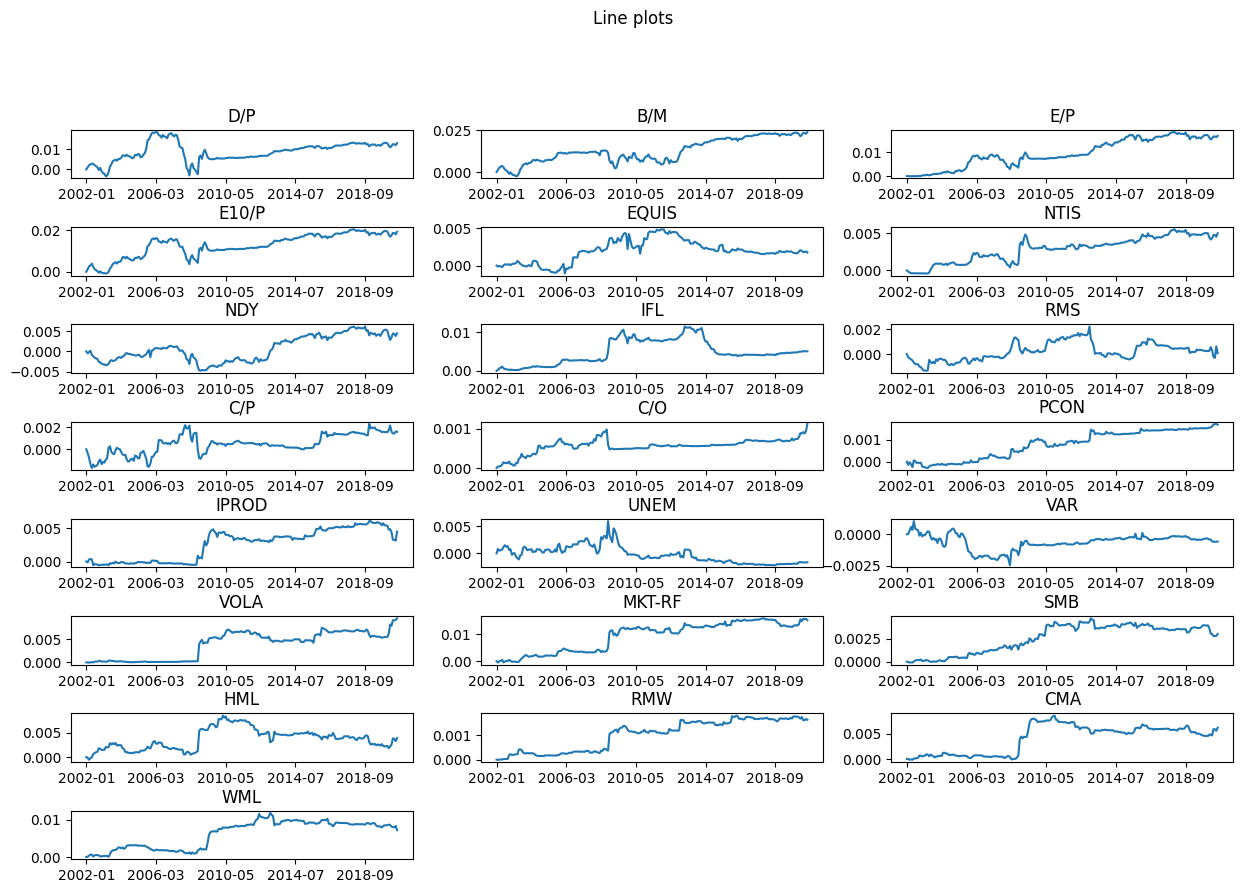

In [585]:
figuresOosUVDF = pd.DataFrame(np.transpose(figuresOosUV))
figuresOosUVDF = figuresOosUVDF.set_index(dates)
figuresOosUVDF.columns = finalmonthlyOnlyIV.columns


plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=1)
plt.suptitle("Line plots")

for i, col in enumerate(figuresOosUVDF.columns):
    ax = plt.subplot(10, 3, i + 1)

    figuresOosUVDF[col].plot(ax=ax)

    ax.set_title(col.upper())
    ax.set_xlabel("")

Multivariate Out of Sample approach
First: Calculating the weightes

In [586]:
tempRapach = rapachTabelle.copy()
rapachTabelle = pd.DataFrame(rapachTabelle)
rapachTabelle.round(5)
rapachTabelle.columns = finalmonthlyOnlyIV.columns

#mean
rapachTabelle["mean"] = rapachTabelle.mean(axis=1)
#median
rapachTabelle["median"] = rapachTabelle.median(axis = 1)

#trimmed mean
tempRapach[np.arange(len(rapachTabelle)), rapachTabelle.values.argmax(1)] = 0
tempRapach[np.arange(len(rapachTabelle)), rapachTabelle.values.argmin(1)] = 0
tempRapach = pd.DataFrame(tempRapach)
rapachTabelle["trimmedMean"] = tempRapach.sum(axis = 1) / (anzahlIV - 2)

In [587]:
# Set index
rapachTabelle = rapachTabelle.set_index(dates)
rapachTabelle

,D/P,B/M,E/P,E10/P,Equis,Ntis,Ndy,Ifl,Rms,C/P,...,Vola,Mkt-RF,SMB,HML,RMW,CMA,WML,mean,median,trimmedMean
Date,,,,,,,,,,,,,,,,,,,,,
2002-01,0.010805,0.014291,-0.004261,0.012182,-0.004969,-0.005518,-0.008432,-0.000779,-0.006423,-0.007259,...,-0.003907,-0.009072,-0.004180,-0.005298,-0.003592,-0.003464,-0.002400,-0.001898,-0.003907,-0.002349
2002-02,0.008617,0.013720,-0.003260,0.013122,-0.002345,-0.004252,0.000114,0.000937,-0.004002,-0.007053,...,-0.003237,0.001383,-0.003457,-0.006961,-0.003075,-0.004925,-0.000392,-0.000709,-0.002345,-0.001114
2002-03,0.005708,0.011285,-0.002940,0.011788,-0.004307,-0.005053,0.004432,0.000676,-0.005003,-0.013013,...,-0.002860,0.002070,-0.002818,0.005763,-0.002896,-0.001018,0.004829,0.000048,-0.001018,0.000114
2002-04,0.002891,0.004909,-0.002390,0.010870,-0.004048,-0.002746,-0.013647,0.001203,-0.003592,-0.007018,...,-0.001548,0.002145,-0.002905,-0.000298,-0.002708,-0.003802,-0.003078,-0.001951,-0.002708,-0.002007
2002-05,-0.002522,0.002389,-0.003278,0.005359,-0.004758,-0.003258,-0.001046,-0.000772,-0.002274,-0.005235,...,-0.002902,0.002296,-0.004024,-0.007219,-0.003412,-0.004856,-0.000413,-0.002597,-0.003258,-0.002745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04,0.008318,0.009801,0.006783,0.009788,-0.000303,0.004021,0.008303,0.001619,-0.003046,-0.000323,...,0.010103,0.007364,-0.000707,0.010967,-0.000118,0.010704,-0.000322,0.003630,0.001619,0.003795
2020-05,0.007088,0.007230,0.004721,0.008574,-0.000363,0.004044,0.008012,0.001871,-0.008358,0.001441,...,0.003371,0.009266,-0.001191,0.011257,0.000279,0.005327,0.003885,0.002621,0.002621,0.002738
2020-06,0.006650,0.006744,0.004440,0.008010,-0.000439,0.003686,0.007570,0.001502,-0.015897,-0.001978,...,-0.000378,0.000318,0.000566,0.006219,0.000079,0.004681,-0.004570,0.001406,0.000738,0.001941


In [588]:
###DMPSE combination
discountFactor1 = 0.9
discountFactor2 = 1.0
###TODO Missing restgit push


Logistic regression

In [589]:
results_log = np.empty(shape=(0, 4))
predictions_log = []

log_df = finalIndexMonthly.iloc[:, :-4].copy()
log_df.loc[log_df["K1"] < 0, "K1" ] = 0
log_df.loc[log_df["K1"] > 0, "K1" ] = 1

for date in dates:
    out_of_sample = finalmonthlyOnlyIV.loc[date]
    df = log_df.loc[:date]
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1:]
    glm = sm.GLM(y, X, family=sm.families.Binomial()).fit()
    temp = np.matrix([[date] * len(glm.params)] + [glm.params.tolist()] + [glm.tvalues.tolist()] + [glm.params.index.tolist()])

    temp = np.transpose(temp)
    results_log = np.vstack((results_log, temp))

    prediction = [date, glm.predict(out_of_sample)[0]]
    predictions_log.append(prediction)

pred_df_log = pd.DataFrame(predictions_log)
pred_df_log = pred_df_log.rename(columns={0: "Date", 1: "Pred_log"})
pred_df_log.set_index('Date', inplace=True)

results_log = pd.DataFrame(results_log)
results_log = results_log.rename(columns={0: "Date", 1: "Coef", 2: "T-val", 3: "Variable"})
results_log.set_index("Date", inplace=True)

results_log[["Coef", "T-val"]] = results_log[["Coef", "T-val"]].apply(pd.to_numeric)
results_log = results_log.round(2)

pred_df_log.loc[pred_df_log["Pred_log"] < 0.5, "Pred_log" ] = 0
pred_df_log.loc[pred_df_log["Pred_log"] >= 0.5, "Pred_log" ] = 1

pred_df_log = pred_df_log.merge(log_df["K1"], on="Date")
pred_df_log

,Pred_log,K1
Date,,
2002-01,0.0,1.0
2002-02,0.0,1.0
2002-03,0.0,1.0
2002-04,0.0,1.0
2002-05,0.0,0.0
...,...,...
2020-04,1.0,1.0
2020-05,1.0,1.0
2020-06,0.0,0.0


In [590]:
confusion_matrix = pd.crosstab(pred_df_log['K1'], pred_df_log['Pred_log'], rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted  0.0  1.0
Actual             
0.0         42   51
1.0         29  102


In [591]:
# I make dataframe from rhmean that I can merge it to df2
rhmeanDF = pd.DataFrame(rhmean)
rhmeanDF = rhmeanDF.set_index(dates)
rhmeanDF = rhmeanDF.rename(columns={0: "rhmean"})

# Final df2 contains rhmean, realized return and "all" multivariate predictions
df2 = pd.DataFrame(finalIndexMonthly["K1"]).merge(rhmeanDF, on="Date")
df2 = df2.merge(pred_df, on="Date")
df2 = df2.merge(rapachTabelle.iloc[:, -3:], on="Date")
df2 = df2.merge(pred_df_log["Pred_log"], on="Date")
df2 = df2.merge(pred_df_vif, on="Date")

#Ask Conway
df2["Pred_log"] = df2["Pred_log"] * df2["rhmean"]

resultsForecastMV = np.zeros((len(df2.columns) - 2, 3))
figuresOosMV = list()

varianceUT.index = df2.index

i = 0
row_names = []

for prediction in df2.iloc[:,2:]:
    #R^2 os
    rNormalR2os = 1 - ((np.square(df2["K1"] - df2[prediction])).sum()/(np.square(df2["K1"] - df2["rhmean"])).sum())

    resultsForecastMV[i,0] = round(rNormalR2os*100,2)

    #adjusted MSPE following Clark and West (2007) to get pval
    rAdjustMspe = np.square(df2["K1"]-df2["rhmean"]) - (np.square(df2["K1"]-df2[prediction]) - np.square(df2["rhmean"] - df2[prediction]))
    rAdjustMspeTest_statistic, rAdjustMspeTest_pvalKIT = stats.ttest_1samp(rAdjustMspe, popmean = 0, alternative = 'greater')

    resultsForecastMV[i,1] = round(rAdjustMspeTest_pval, 3)


    sqm = list()
    for k in df2.index:
        sqm.append(np.square(df2.loc[:k, "K1"] - df2.loc[:k, "rhmean"]).sum() - np.square(df2.loc[:k, "K1"] - df2.loc[:k, prediction]).sum())
    figuresOosMV.append(sqm)


    wVariableKIT = (df2[prediction]*100).div(varianceUT)*(1/riskAversion)

    #restrict wVariable to max 0% or 150%
    wVariableKIT
    for a in wVariableKIT.index:
        if wVariableKIT[a] < 0:
            wVariableKIT[a] = 0
        elif wVariableKIT[a] > 1.5:
            wVariableKIT[a] = 1.5
        else:
            True
            #do nothing

    utilityPredKIT = wVariableKIT.mean()-(1/2*riskAversion*wVariableKIT.var())
    gainKIT = (utilityPredKIT - historicUtility)*1200
    resultsForecastMV[i,2] = round(gainKIT,2)
    row_names.append(prediction)
    i += 1

resultsForecastMV = pd.DataFrame(resultsForecastMV)
resultsForecastMV.columns = ["R^2OS", "pval", "Ugain"]
resultsForecastMV.index = row_names

resultsForecastMV

,R^2OS,pval,Ugain
Pred,-12.11,0.034,11.65
mean,2.05,0.034,1.28
median,0.93,0.034,0.49
trimmedMean,1.85,0.034,1.13
Pred_log,-0.59,0.034,-0.03
Pred_vif,-11.32,0.034,14.04


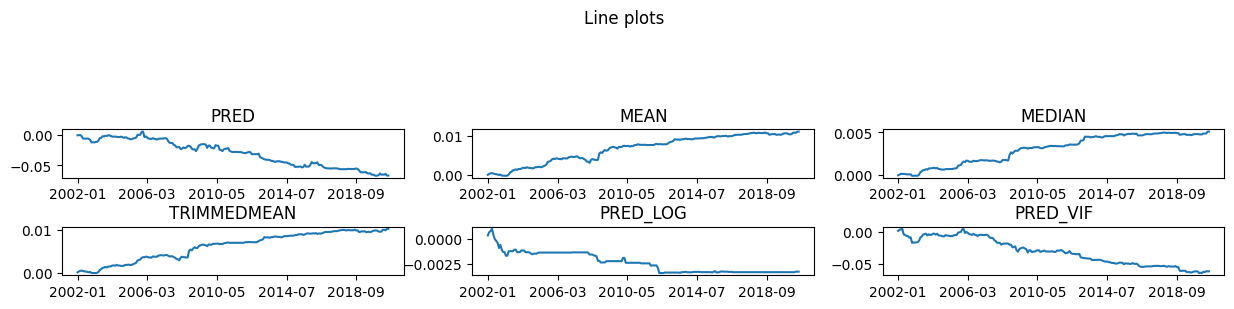

In [592]:
figuresOosMVDF = pd.DataFrame(np.transpose(figuresOosMV))
figuresOosMVDF = figuresOosMVDF.set_index(dates)
figuresOosMVDF.columns = df2.columns[2:]


plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=1)
plt.suptitle("Line plots")

for i, col in enumerate(figuresOosMVDF.columns):
    ax = plt.subplot(10, 3, i + 1)

    figuresOosMVDF[col].plot(ax=ax)

    ax.set_title(col.upper())
    ax.set_xlabel("")

In [593]:
np.corrcoef(df2["Pred"], df2["K1"])

array([[1.        , 0.06314098],
       [0.06314098, 1.        ]])

<AxesSubplot: xlabel='Date'>

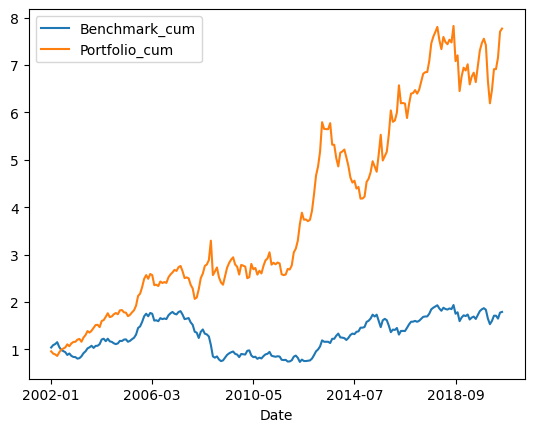

In [594]:
weights = pred_df_log.copy()
weights.loc[weights["Pred_log"] == 0.0, 'Pred_log'] = -1
weights = weights.drop(columns="K1")
weights = weights.merge(finalIndexMonthly["K1"], on="Date")
weights["Portfolio"] = weights["Pred_log"] * weights["K1"]
weights["Benchmark_cum"] = (1 + weights["K1"]).cumprod()
weights["Portfolio_cum"] = (1 + weights["Portfolio"]).cumprod()


weights.plot(y=["Benchmark_cum", "Portfolio_cum"])